# Språkprosessering og analyse - Capgeminis CVer

In [19]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import os
import sys
import gensim
from wordcloud import WordCloud

In [2]:
sns.set(rc={'figure.figsize':(15, 8)})

In [3]:
cv_path = os.path.join(os.getcwd(), 'data', 'sharepoint', 'cv')
cvs = os.listdir(cv_path)

In [4]:
get_cv = lambda name : os.path.join(cv_path, name)

## Preprosessering

In [5]:
spacy_model = 'nb_core_news_lg'
nlp = spacy.load(spacy_model)
nlp.add_pipe('sentencizer')

In [6]:
def flat_map(xs):
    ys = []
    for x in xs:
        ys.extend(x)
    return ys

def clean_sent(sent):
    escapes = ['\n', '\t', '\r']
    
    def valid(tok):
        return tok not in escapes
    
    for e in escapes:
        sent = sent.replace(e, ' ')
    
    return sent

MIN_LEN = 20        
def get_sentences(data):
    sents = []
    for sent in data:
        # clean the raw text
        cleaned = clean_sent(sent).strip()
        
        # parse possible sub-sentences using spacy
        doc = nlp(cleaned)
        sub_sents = [s.text for s in doc.sents if len(s.text) > MIN_LEN]
        sents.append(sub_sents)
    return flat_map(sents)

In [7]:
all_texts = []
all_labels = []

for cv_name in cvs:
    with open(get_cv(cv_name), 'r', encoding='utf-8') as f:
        data = f.readlines()
        sents = get_sentences(data)
        all_texts.extend(sents)
        labels = len(sents) * [cv_name.replace('.txt', '')]
        all_labels.extend(labels)

## Gjør om til tabulær data

In [8]:
columns = ['text', 'konsulent']
df = pd.DataFrame(list(zip(all_texts, all_labels)), columns=columns)
df

,text,konsulent
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen
4,i et domain driven design-mønster.,albert danielsen
...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness
1384,Administrator Associate,vegard walmsness
1385,Certified Fundamentals,vegard walmsness
1386,Administering and Deploying System Center Conf...,vegard walmsness


In [9]:
sample = df.text[1]
sample

'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.'

In [10]:
doc = nlp(sample)
print([token.lemma_ for token in doc])
print([tok for tok in doc])

['han', 'har', 'opparbeide', 'seg', 'bred', 'erfaring', 'innen', 'programvareutvikling', 'fra', 'sine', 'prosjekt', 'hos', 'tidlig', 'arbeidsgiver', 'og', 'som', 'konsulent', '.']
[Han, har, opparbeidet, seg, bred, erfaring, innen, programvareutvikling, fra, sine, prosjekter, hos, tidligere, arbeidsgivere, og, som, konsulent, .]


In [11]:
def get_ent(ent):
    return [ent.text, ent.start_char, ent.end_char, ent.label_]

def enrich(row):
    doc = nlp(row.text)
    
    lemmas = [token.lemma_ for token in doc]
    row['lemmas'] = lemmas
    
    ents = [get_ent(ent) for ent in doc.ents]
    row['ents'] = ents
    
    tokens = [tok for tok in doc]
    row['tokens'] = tokens
    
    return row

df = df.apply(enrich, axis=1)

In [12]:
df

,text,konsulent,lemmas,ents,tokens
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen,"[Albert, er, en, svilingeniør, innen, kybernet...","[[Albert, 0, 6, PER], [NTNU, 70, 74, ORG]]","[Albert, er, en, svilingeniør, innen, kybernet..."
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen,"[han, har, opparbeide, seg, bred, erfaring, in...",[],"[Han, har, opparbeidet, seg, bred, erfaring, i..."
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen,"[nylig, har, Albert, jobbe, i, et, prosjekt, f...","[[Albert, 10, 16, PER], [Altera Infrastructure...","[Nylig, har, Albert, jobbet, i, et, prosjekt, ..."
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen,"[hans, bidrag, i, dette, prosjekt, bestå, i, f...","[[Vue, 103, 106, ORG]]","[Hans, bidrag, i, dette, prosjektet, består, i..."
4,i et domain driven design-mønster.,albert danielsen,"[i, et, domain, driven, design-mønster, .]",[],"[i, et, domain, driven, design-mønster, .]"
...,...,...,...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness,"[2019-07, -, Microsoft, 365, Certified, :]","[[Microsoft, 10, 19, ORG]]","[2019-07, -, Microsoft, 365, Certified, :]"
1384,Administrator Associate,vegard walmsness,"[administrator, Associate]",[],"[Administrator, Associate]"
1385,Certified Fundamentals,vegard walmsness,"[Certified, Fundamentals]",[],"[Certified, Fundamentals]"
1386,Administering and Deploying System Center Conf...,vegard walmsness,"[Administering, and, Deploying, System, Center...",[],"[Administering, and, Deploying, System, Center..."


In [13]:
def get_texts_from_name(name, field='text'):
    return list(df[(df.konsulent.str.contains(name))][field])

get_texts_from_name('albert')[:3]

['Albert er en svilingeniør innen kybernetikk og robotikk, utdannet ved NTNU, med spesialisering innen embedded systems.',
 'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.',
 'Nylig har Albert jobbet i et prosjekt for Altera Infrastructure, et stort skipsrederi, med mål om å digitalisere arbeidsflyten ved modifikasjoner på skip i drift.']

In [14]:
STOPPORD = ['gjennom', 'as', 'innen', 'å', 'alle', 'at', 'av', 'både', 'båe', 'bare', 'begge', 'ble', 'blei', 'bli', 'blir', 'blitt', 'då', 'da', 'de', 'deg', 'dei', 'deim', 'deira', 'deires', 'dem', 'den', 'denne', 'der', 'dere', 'deres', 'det', 'dette', 'di', 'din', 'disse', 'ditt', 'du', 'dykk', 'dykkar', 'eg', 'ein', 'eit', 'eitt', 'eller', 'elles', 'en', 'enn', 'er', 'et', 'ett', 'etter', 'før', 'for', 'fordi', 'fra', 'ha', 'hadde', 'han', 'hans', 'har', 'hennar', 'henne', 'hennes', 'her', 'hjå', 'ho', 'hoe', 'honom', 'hoss', 'hossen', 'hun', 'hva', 'hvem', 'hver', 'hvilke', 'hvilken', 'hvis', 'hvor', 'hvordan', 'hvorfor', 'i', 'ikke', 'ikkje', 'ingen', 'ingi', 'inkje', 'inn', 'inni', 'ja', 'jeg', 'kan', 'kom', 'korleis', 'korso', 'kun', 'kunne', 'kva', 'kvar', 'kvarhelst', 'kven', 'kvi', 'kvifor', 'man', 'mange', 'me', 'med', 'medan', 'meg', 'meget', 'mellom', 'men', 'mi', 'min', 'mine', 'mitt', 'mot', 'mykje', 'nå', 'når', 'ned', 'no', 'noe', 'noen', 'noka', 'noko', 'nokon', 'nokor', 'nokre', 'og', 'også', 'om', 'opp', 'oss', 'over', 'på', 'så', 'sånn', 'samme', 'seg', 'selv', 'si', 'sia', 'sidan', 'siden', 'sin', 'sine', 'sitt', 'sjøl', 'skal', 'skulle', 'slik', 'so', 'som', 'somme', 'somt', 'til', 'um', 'upp', 'ut', 'uten', 'vår', 'være', 'vært', 'var', 'vart', 'varte', 'ved', 'vere', 'verte', 'vi', 'vil', 'ville', 'vore', 'vors', 'vort']
len(STOPPORD)

175

In [15]:
NAVN = [cv.replace('.txt', '').split() for cv in cvs]
NAVN = flat_map(NAVN)

In [16]:
FY_ORD = []
FY_ORD.extend(STOPPORD)
FY_ORD.extend(NAVN)

In [17]:
corpus = [tok.text.lower() for tok in flat_map(list(df.tokens)) if len(tok) > 1]
len(corpus)

14666

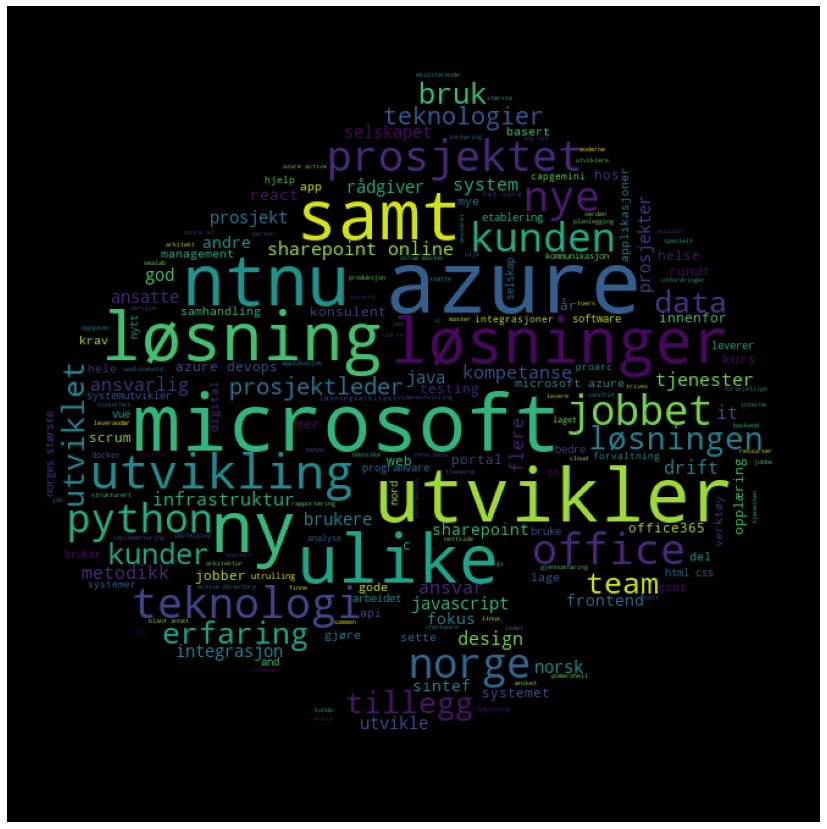

In [20]:
from PIL import Image

logo_path = os.path.join(os.getcwd(), 'data', 'cap.jpg')
generated_logo_path = os.path.join(os.getcwd(), 'data', 'cap-cloud.jpg')
cap_mask = np.array(Image.open(logo_path))

def create_masked_wc(data, ngram=False):
    wc = WordCloud(background_color="black",
                   max_words=200,
                   max_font_size=70,
                   mask=cap_mask,
                   stopwords=FY_ORD,
                   contour_width=0,
                   width=1000,
                   height=1000)

    if ngram:
        wc.generate_from_frequencies(data)
    else:
        wc.generate(' '.join(data))


    # store to file
    # wc.to_file(generated_logo_path)

    # show
    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

create_masked_wc(corpus)

In [21]:
lemmas = [' '.join(x) for x in list(df.lemmas)]
def get_ents_for_name(name):
    ents = get_texts_from_name(name, 'ents')
    ents = [e for e in list(ents) if len(e) > 0]
    ents = [e[0] for e in flat_map(ents)]
    return ents
    
ents = [e for e in list(df.ents) if len(e) > 0]
ents = [e[0] for e in flat_map(ents)]

# Med entiteter

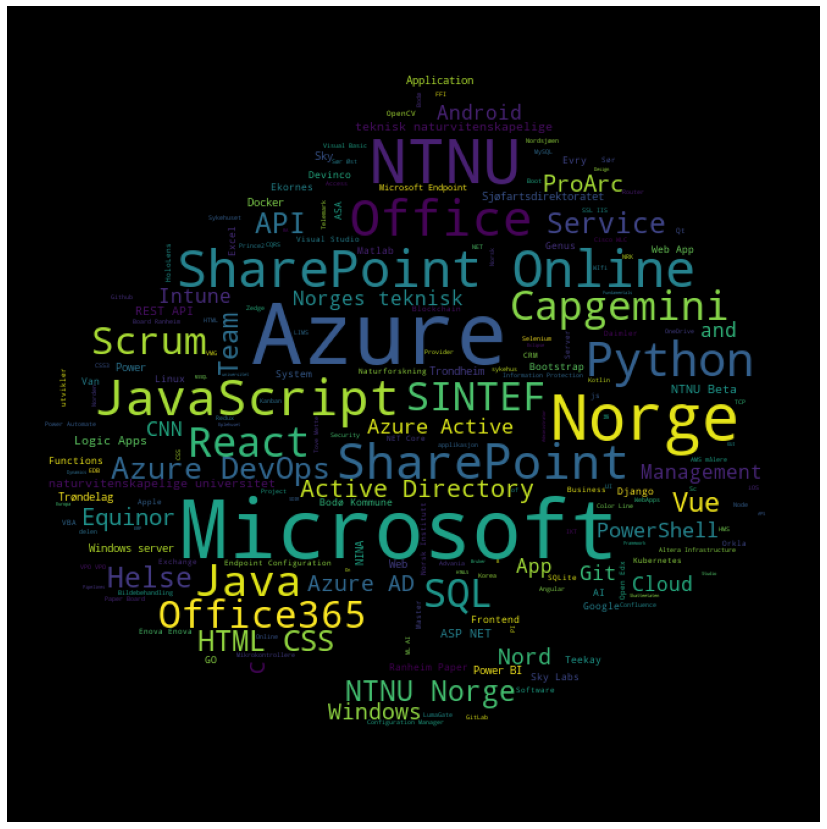

In [22]:
create_masked_wc(ents, False)

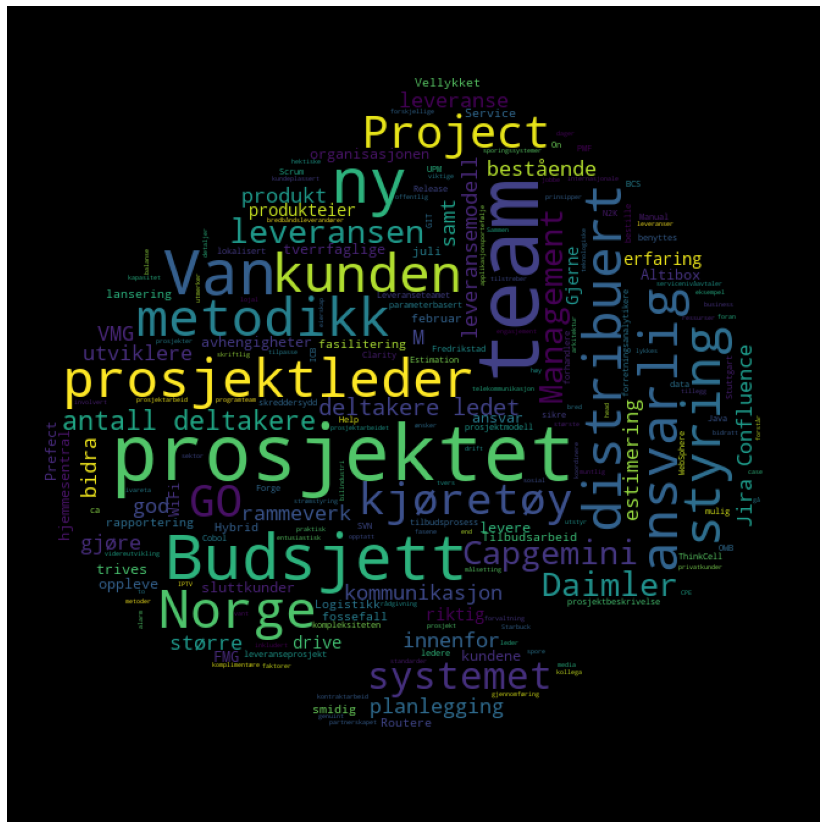

In [23]:
_tekst = get_texts_from_name('richard', 'text')
create_masked_wc(_tekst, False)

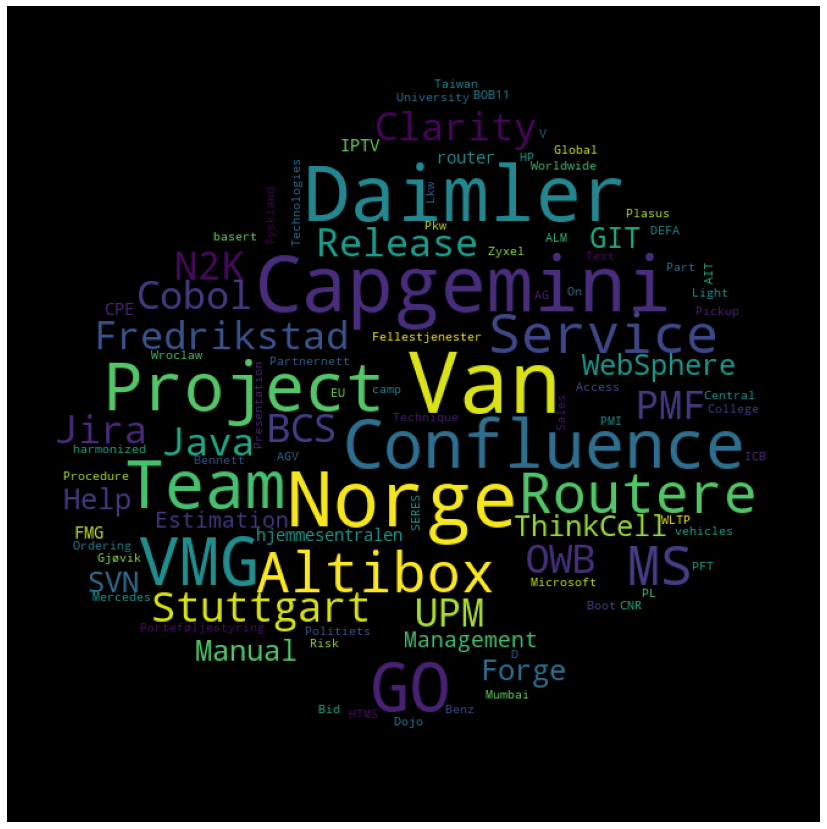

In [24]:
_ents = get_ents_for_name('richard')
create_masked_wc(_ents, False)

## n-grams

In [25]:
def ngrams_to_corpus(ngrams):
    corpus = []
    for text, count in ngrams:
        corpus.extend([text]*count)
    return corpus

In [26]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n, returning=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:returning]

In [27]:
ngram = get_top_ngram(lemmas, 2)
ngram

[('er en', 47),
 ('office 365', 30),
 ('og teknologi', 28),
 ('er et', 28),
 ('ansvar for', 26),
 ('sharepoint online', 25),
 ('ansvarlig for', 22),
 ('bruk av', 21),
 ('utvikling av', 20),
 ('metodikk og', 20)]

In [28]:
trigram = get_top_ngram(lemmas, 3)
trigram

[('metodikk og teknologi', 16),
 ('ha ansvar for', 10),
 ('ved hjelp av', 9),
 ('sette seg inn', 9),
 ('på tvers av', 8),
 ('azure active directory', 8),
 ('og utvikling av', 7),
 ('norges teknisk naturvitenskapelig', 7),
 ('teknisk naturvitenskapelig universitet', 7),
 ('er norges størst', 7)]

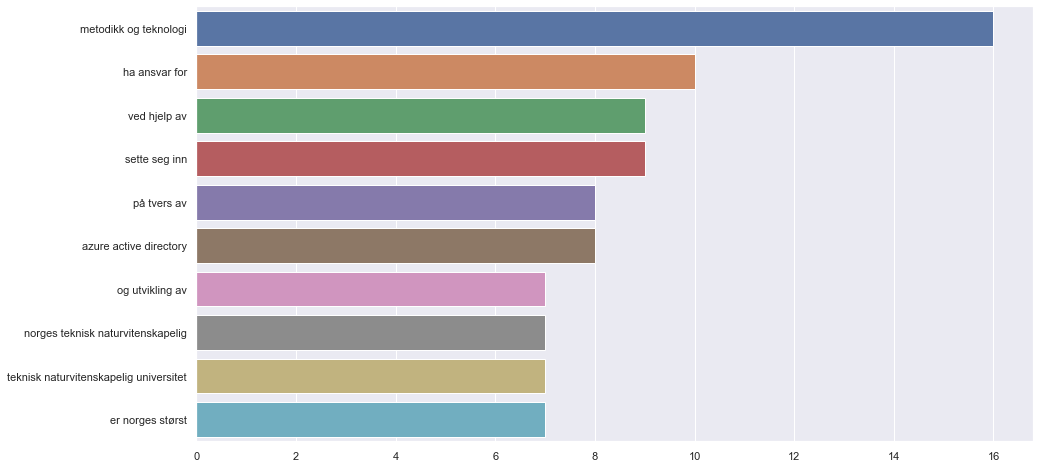

In [29]:
from collections import Counter

def plot_grams(data, n=20):
    x, y = [], []
    for word,count in data:
        if (word.lower() not in FY_ORD):
            x.append(count)
            y.append(word)

    sns.barplot(x=x[:n], y=y[:n])

plot_grams(trigram, 30)

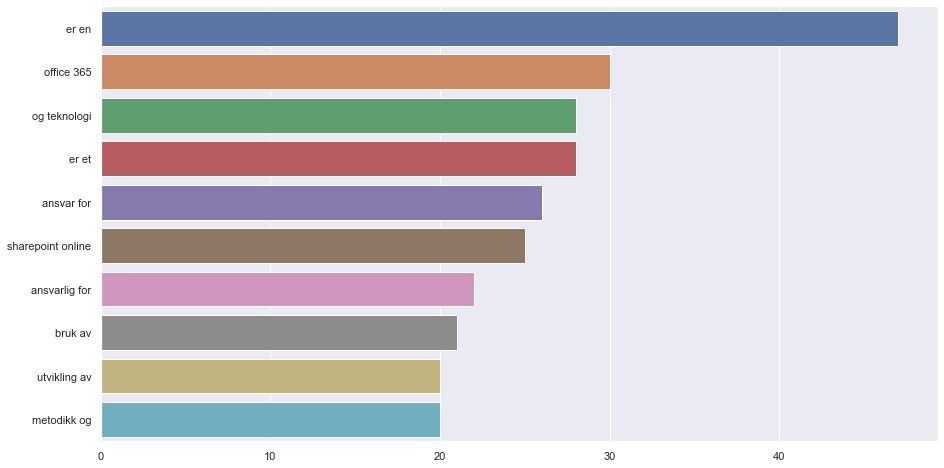

In [30]:
plot_grams(ngram, 30)

## Topic modeling

In [31]:
all_toks = [tok for tok in list(df.tokens) if tok not in STOPPORD and len(tok) > 1]

In [37]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()


def topic_model(tokens, grouped=False, topics=2):
    bow = []
    if grouped:
        for grouped_tok in list(tokens):
            parsed = []
            for tok in grouped_tok:
                if len(tok) > 1 and tok.text not in STOPPORD:
                    parsed.append(tok.text.lower())
            bow.append(parsed)
    else:
        bow = [[t] for t in tokens]
        
    PASSES = 20
    WORKERS = 4

    gen_corp = gensim.corpora.Dictionary(bow)
    bow_corpus = [gen_corp.doc2bow(doc) for doc in bow]
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = topics, 
                                       id2word = gen_corp,                                    
                                       passes = PASSES,
                                       workers = WORKERS)

    return [lda_model, bow_corpus, gen_corp]
    
#topic_model(df.tokens)
lda_model, bow_corpus, gen_corpus = topic_model(df.tokens, grouped=True, topics=5)
lda_model.show_topics()

[(0,
  '0.008*"utvikler" + 0.008*"teknologi" + 0.005*"ny" + 0.005*"jobbet" + 0.004*"scrum" + 0.004*"design" + 0.004*"as" + 0.004*"erfaring" + 0.004*"sky" + 0.003*"metodikk"'),
 (1,
  '0.010*"as" + 0.007*"hun" + 0.006*"ansvarlig" + 0.006*"løsninger" + 0.005*"norge" + 0.004*"norsk" + 0.003*"samt" + 0.003*"ansvar" + 0.003*"prosjektleder" + 0.003*"planlegging"'),
 (2,
  '0.009*"ntnu" + 0.006*"python" + 0.006*"teknologier" + 0.005*"han" + 0.005*"utvikling" + 0.005*"prosjektet" + 0.004*"c++" + 0.004*"lage" + 0.004*"2020-06" + 0.004*"løsninger"'),
 (3,
  '0.034*"azure" + 0.018*"microsoft" + 0.012*"365" + 0.012*"sharepoint" + 0.011*"office" + 0.008*"online" + 0.006*"han" + 0.006*"ny" + 0.005*"devops" + 0.005*"løsning"'),
 (4,
  '0.010*"ntnu" + 0.007*"norges" + 0.007*"største" + 0.006*"universitet" + 0.005*"python" + 0.005*"utvikler" + 0.005*"prosjektet" + 0.004*"erfaring" + 0.004*"html" + 0.004*"css"')]

In [188]:
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, gen_corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.171951 -0.002129       1        1  26.433536
4      0.036394 -0.076909       2        1  19.974450
2      0.054231 -0.084734       3        1  19.613377
0      0.048223  0.106269       4        1  17.049989
1      0.033103  0.057502       5        1  16.928648, topic_info=           Term       Freq      Total Category  logprob  loglift
50        azure  91.000000  91.000000  Default  30.0000  30.0000
109   microsoft  55.000000  55.000000  Default  29.0000  29.0000
338         365  34.000000  34.000000  Default  28.0000  28.0000
339      office  30.000000  30.000000  Default  27.0000  27.0000
410  sharepoint  36.000000  36.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
12          han   4.906763  42.228540   Topic5  -5.8685  -0.3763
425     tillegg   3.831714  20.256887   Topic5  -6.1158   0.1110
463   teknologi   3.600213  23.078960   Topic5  -6.1781  -0.0818
651         nye   3.598157  24.946372   Topic5  -6.1786  -0.1601
160     største   3.573396  25.083274   Topic5  -6.1855  -0.1725

[354 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
32        1  0.499149        .net
32        2  0.356535        .net
32        3  0.142614        .net
1125      2  0.696515  2008/2012.
3819      4  0.859562     2013-03
...     ...       ...         ...
577       2  0.162097     windows
577       3  0.081048     windows
577       5  0.324193     windows
359       3  0.284875        with
359       5  0.569750        with

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

In [189]:
#TODOS:

# list POS tree with displacy
# doc = nlp('The greatest comeback stories in 2019')
# displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [190]:
def get_pos(pos_type):
    tokens = []
    for token_list in df.tokens:
        for token in token_list:
            if token.pos_ == pos_type:
                tokens.append(token.text.lower())
    return tokens

In [191]:
def show_pos(pos_type='NOUN', n = 10):
    count = Counter(get_pos(pos_type)).most_common(n)
    y = [i[0] for i in count]
    x = [i[1] for i in count]
    sns.barplot(x=x[:n], y=y[:n])

# Topp 10 substantiv

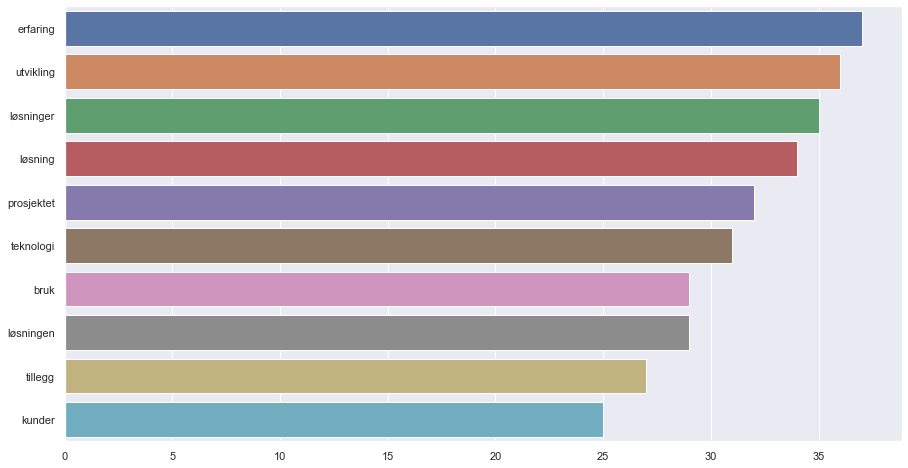

In [192]:
show_pos('NOUN')

# Topp 10 verb

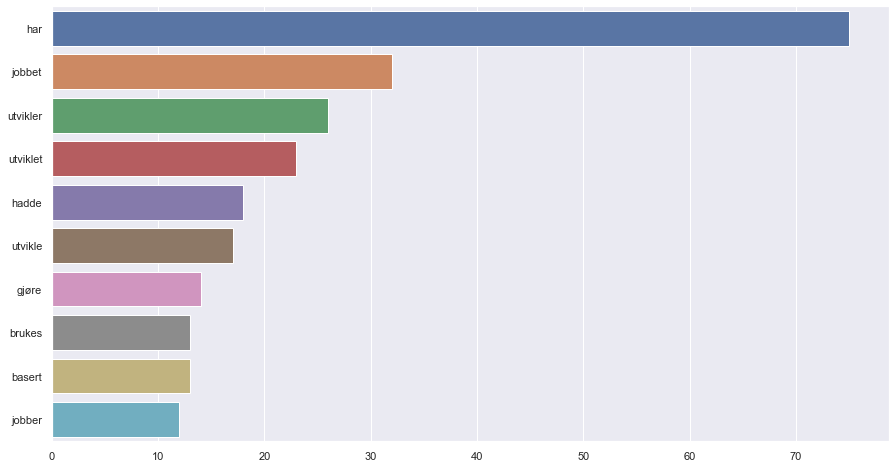

In [193]:
show_pos('VERB')

# Topp 10 adjektiv

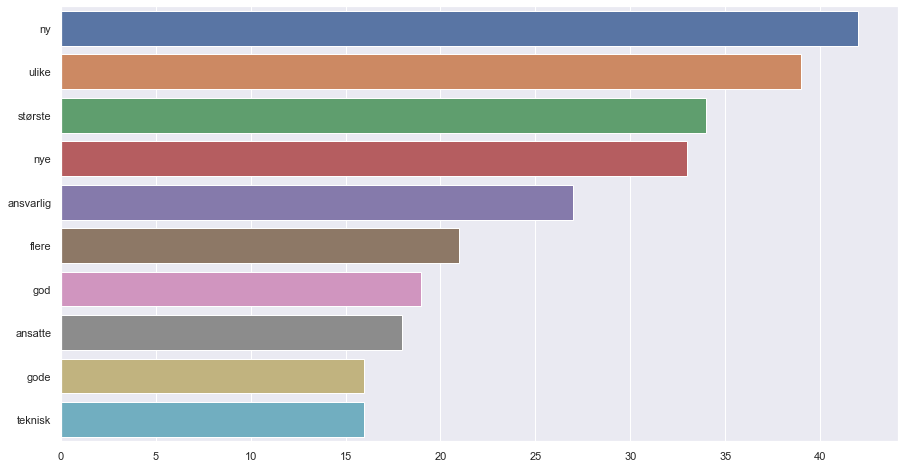

In [194]:
show_pos('ADJ', 10)

## Koordinerte konjuksjoner (bindeord)

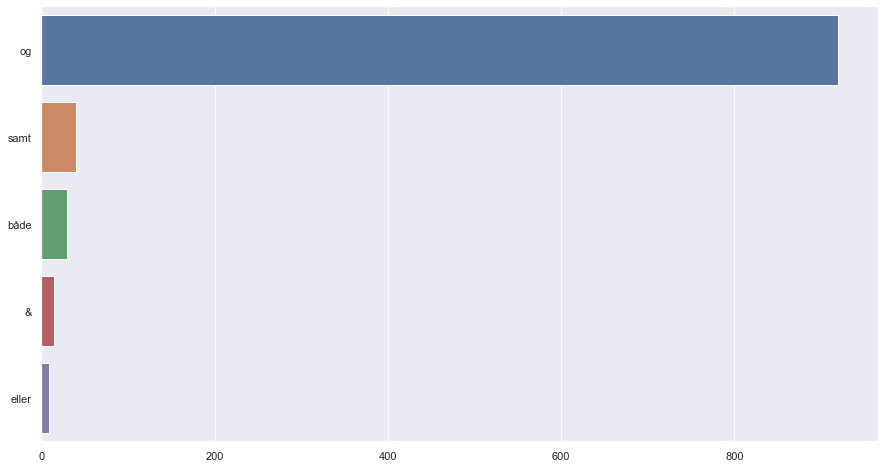

In [196]:
show_pos('CCONJ', 5)